<a href="https://colab.research.google.com/github/EricSiq/India_Missing_Persons_Analysis_2017-2022/blob/main/ClusteringUMLProject2v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Kaggle Dataset: 5 Years Districtwise India Missing Person's Dataset](https://www.kaggle.com/datasets/ericsiq/india-5-years-districtwise-missing-persons-dataset)


[GitHub Repo](https://github.com/EricSiq/India_Missing_Persons_Analysis_2017-2022)

In [183]:
!pip install tabulate



# Overview:

> This notebook demonstrates how to load multiple CSV datasets spanning the years, 2017 to 2022, merge them into a single dataframe, and perform several data processing and exploratory data analysis (EDA) steps. The sections below cover:







In [184]:
# Importing libraries
import pandas as pd         # For data manipulation and analysis
import numpy as np          # For numerical operations
import matplotlib.pyplot as plt  # For plotting graphs
import seaborn as sns       # For enhanced visualization
from tabulate import tabulate #For tabular outputs
from sklearn.preprocessing import StandardScaler # For Feature scaling
from sklearn.metrics import silhouette_score #Accuracy Metrics
from sklearn.decomposition import PCA #For graphical representation
from sklearn.cluster import KMeans #For k means clustering



# Data Loading



> Upon loading of the datasets, it is noticed there is a serious disrepancy between column values for age groups.



The age group classifications differ notably between the 2018–2020 and 2021–2022 datasets:


2018–2020: Age brackets are more granular and traditional:

Below 5 years

5–14 years

14–18 years

18–30 years

30–45 years

45–60 years

60 years & above



In 2021–2022: The classification structure has changed:

Below 12 years

12–16 years

16–18 years

18 years & above

In [185]:
%matplotlib inline

# Setting a style for seaborn plots
sns.set(style="whitegrid")

In [186]:

# Section 1: Define file paths for each year's data.
file_paths = {
    2018: "/content/DistrictwiseMissingPersons2018.csv",
    2019: "/content/DistrictwiseMissingPersons2019.csv",
    2020: "/content/DistrictwiseMissingPersons2020.csv",
    2021: "/content/DistrictwiseMissingPersons2021.csv",
    2022: "/content/DistrictwiseMissingPersons2022.csv"
}




> Due to disrepancies between columns, we need to remove unnessessary columns and make them uniform across 2018-2022 years.

> We have to group all age groups into either Children or 18+ age groups to simplify the age groups.



#   Data Cleaning:
1.     - Reading the CSV files into pandas dataframes.
2.     - Removing Unnessessary Column values
3.     - Examining initial structure & description of the data.

In [187]:

# A list to hold all processed DataFrames.
dfs = []

# Section 2: Process each dataset according to its year.
for year, path in file_paths.items():
    # Load file with fallback encoding if necessary
    try:
        df = pd.read_csv(path)
    except UnicodeDecodeError:
        try:
            df = pd.read_csv(path, encoding='ISO-8859-1')
            print(f"Used fallback encoding for {year}")
        except Exception as e:
            print(f"Failed to load {year}: {e}")
            continue

    # Add the year column if not already present.
    df['Year'] = year

    # Remove any leading/trailing whitespace from column headers.
    df.columns = df.columns.str.strip()

    if year <= 2020:
        # For datasets 2018-2020, we have the detailed age-group columns.
        # Male columns
        male_below_18 = [
            'Male_Below_5_years',
            'Male_5_years_&_Above_Below_14_years',
            'Male_14_years_&_Above_Below_18_years'
        ]
        male_above_18 = [
            'Male_18_years_&_Above_Below_30_years',
            'Male_30_years_&_Above_Below_45_years',
            'Male_45_years_&_Above_Below_60_years',
            'Male_60_years_&_Above'
        ]

        # Female columns
        female_below_18 = [
            'Female_Below_5_years',
            'Female_5_years_&_Above_Below_14_years',
            'Female_14_years_&_Above_Below_18_years'
        ]
        female_above_18 = [
            'Female_18_years_&_Above_Below_30_years',
            'Female_30_years_&_Above_Below_45_years',
            'Female_45_years_&_Above_Below_60_years',
            'Female_60_years_&_Above'
        ]

        # Transgender columns
        trans_below_18 = [
            'Transgender_Below_5_years',
            'Transgender_5_years_&_Above_Below_14_years',
            'Transgender_14_years_&_Above_Below_18_years'
        ]
        trans_above_18 = [
            'Transgender_18_years_&_Above_Below_30_years',
            'Transgender_30_years_&_Above_Below_45_years',
            'Transgender_45_years_&_Above_Below_60_years',
            'Transgender_60_years_&_Above'
        ]

        # Total columns
        total_below_18 = [
            'Total_Below_5_years',
            'Total_5_years_&_Above_Below_14_years',
            'Total_14_years_&_Above_Below_18_years'
        ]
        total_above_18 = [
            'Total_18_years_&_Above_Below_30_years',
            'Total_30_years_&_Above_Below_45_years',
            'Total_45_years_&_Above_Below_60_years',
            'Total_60_years_&_Above'
        ]

        # Sum up the relevant columns for each group.
        df['Male_Below_18'] = df[male_below_18].sum(axis=1)
        df['Male_18_and_above'] = df[male_above_18].sum(axis=1)

        df['Female_Below_18'] = df[female_below_18].sum(axis=1)
        df['Female_18_and_above'] = df[female_above_18].sum(axis=1)

        df['Transgender_Below_18'] = df[trans_below_18].sum(axis=1)
        df['Transgender_18_and_above'] = df[trans_above_18].sum(axis=1)

        df['Total_Below_18'] = df[total_below_18].sum(axis=1)
        df['Total_18_and_above'] = df[total_above_18].sum(axis=1)

        # Drop the original detailed columns.
        drop_cols = (male_below_18 + male_above_18 +
                     female_below_18 + female_above_18 +
                     trans_below_18 + trans_above_18 +
                     total_below_18 + total_above_18)
        df.drop(columns=drop_cols, inplace=True, errors='ignore')

    else:
        # For 2021-2022, the files already include aggregated age-group columns.
        # Rename them to standardized names.
        rename_map = {
            'Male_Children': 'Male_Below_18',
            'Male_18_years_&_Above': 'Male_18_and_above',
            'Female_Children': 'Female_Below_18',
            'Female_18_years_&_Above': 'Female_18_and_above',
            'Transgender_Children': 'Transgender_Below_18',
            'Transgender_18_years_&_Above': 'Transgender_18_and_above',
            'Total_Children': 'Total_Below_18',
            'Total_18_years_&_Above': 'Total_18_and_above'
        }
        df.rename(columns=rename_map, inplace=True)

        # Drop any extra detailed age-group columns that are not needed.
        drop_cols = [
            'Male_Below_12_years', 'Male_12_years_&_Above_Below_16_years', 'Male_16_years_&_Above_Below_18_years',
            'Female_Below_12_years', 'Female_12_years_&_Above_Below_16_years', 'Female_16_years_&_Above_Below_18_years',
            'Transgender_Below_12_years', 'Transgender_12_years_&_Above_Below_16_years', 'Transgender_16_years_&_Above_Below_18_years',
            'Total_Below_12_years', 'Total_12_years_&_Above_Below_14_years', 'Total_14_years_&_Above_Below_18_years'
        ]
        df.drop(columns=drop_cols, inplace=True, errors='ignore')

    # Append the processed DataFrame to our list.
    dfs.append(df)
    print(f"Loaded and processed data for {year} with shape: {df.shape}")

# Optionally, display a preview of the first processed DataFrame.
print("\nPreview of the processed dataset for the first file:")
print(tabulate(dfs[0].head(10), headers='keys', tablefmt='pretty'))

Loaded and processed data for 2018 with shape: (892, 15)
Loaded and processed data for 2019 with shape: (912, 15)
Loaded and processed data for 2020 with shape: (932, 15)
Loaded and processed data for 2021 with shape: (941, 15)
Loaded and processed data for 2022 with shape: (969, 15)

Preview of the processed dataset for the first file:
+---+------+----------------+------------------+------------+--------------+-------------------+-------------+---------------+-------------------+-----------------+---------------------+----------------------+--------------------------+----------------+--------------------+
|   | Year |     State      |     District     | Total_Male | Total_Female | Total_Transgender | Grand_Total | Male_Below_18 | Male_18_and_above | Female_Below_18 | Female_18_and_above | Transgender_Below_18 | Transgender_18_and_above | Total_Below_18 | Total_18_and_above |
+---+------+----------------+------------------+------------+--------------+-------------------+-------------+-

In [188]:
print(tabulate(dfs[1].head(10), headers='keys', tablefmt='pretty'))

+---+------+----------------+------------------+------------+--------------+-------------------+-------------+---------------+-------------------+-----------------+---------------------+----------------------+--------------------------+----------------+--------------------+
|   | Year |     State      |     District     | Total_Male | Total_Female | Total_Transgender | Grand_Total | Male_Below_18 | Male_18_and_above | Female_Below_18 | Female_18_and_above | Transgender_Below_18 | Transgender_18_and_above | Total_Below_18 | Total_18_and_above |
+---+------+----------------+------------------+------------+--------------+-------------------+-------------+---------------+-------------------+-----------------+---------------------+----------------------+--------------------------+----------------+--------------------+
| 0 | 2019 | Andhra Pradesh |    Anantapur     |    257     |     766      |         0         |    1023     |      60       |        197        |       280       |        486

In [189]:
print(tabulate(dfs[2].head(10), headers='keys', tablefmt='pretty'))

+---+------+----------------+---------------+------------+--------------+-------------------+-------------+---------------+-------------------+-----------------+---------------------+----------------------+--------------------------+----------------+--------------------+
|   | Year |     State      |   District    | Total_Male | Total_Female | Total_Transgender | Grand_Total | Male_Below_18 | Male_18_and_above | Female_Below_18 | Female_18_and_above | Transgender_Below_18 | Transgender_18_and_above | Total_Below_18 | Total_18_and_above |
+---+------+----------------+---------------+------------+--------------+-------------------+-------------+---------------+-------------------+-----------------+---------------------+----------------------+--------------------------+----------------+--------------------+
| 0 | 2020 | Andhra Pradesh |   Anantapur   |    209     |     869      |         0         |    1078     |      32       |        177        |       284       |         585         | 

In [190]:
print(tabulate(dfs[3].head(10), headers='keys', tablefmt='pretty'))

+---+------+----------------+---------------+------------+---------------+-------------------+--------------+-----------------+---------------------+-------------------+----------------------+--------------------------+-------------+----------------+--------------------+
|   | Year |     State      |   District    | Total_Male | Male_Below_18 | Male_18_and_above | Total_Female | Female_Below_18 | Female_18_and_above | Total_Transgender | Transgender_Below_18 | Transgender_18_and_above | Grand_Total | Total_Below_18 | Total_18_and_above |
+---+------+----------------+---------------+------------+---------------+-------------------+--------------+-----------------+---------------------+-------------------+----------------------+--------------------------+-------------+----------------+--------------------+
| 0 | 2021 | Andhra Pradesh |   Anantapur   |    291     |      43       |        248        |     1224     |       446       |         778         |         0         |          0    

In [191]:
print(tabulate(dfs[4].head(10), headers='keys', tablefmt='pretty'))

+---+------+----------------+--------------------------+------------+---------------+-------------------+--------------+-----------------+---------------------+-------------------+----------------------+--------------------------+-------------+----------------+--------------------+
|   | Year |     State      |         District         | Total_Male | Male_Below_18 | Male_18_and_above | Total_Female | Female_Below_18 | Female_18_and_above | Total_Transgender | Transgender_Below_18 | Transgender_18_and_above | Grand_Total | Total_Below_18 | Total_18_and_above |
+---+------+----------------+--------------------------+------------+---------------+-------------------+--------------+-----------------+---------------------+-------------------+----------------------+--------------------------+-------------+----------------+--------------------+
| 0 | 2022 | Andhra Pradesh |  Alluri Sitharama Raju   |     36     |       8       |        28         |      80      |       54        |         26  

#   Pre-processing:
1.      - Analysing dataset values
2.      - Merging the datasets.
2.     - Handling missing values and data type conversions.

In [192]:
print("Columns in the DataFrame:")
print(df.columns.tolist())

Columns in the DataFrame:
['Year', 'State', 'District', 'Total_Male', 'Male_Below_18', 'Male_18_and_above', 'Total_Female', 'Female_Below_18', 'Female_18_and_above', 'Total_Transgender', 'Transgender_Below_18', 'Transgender_18_and_above', 'Grand_Total', 'Total_Below_18', 'Total_18_and_above']


In [193]:
# Concatenate all dataframes into a single dataframe
data = pd.concat(dfs, ignore_index=True)

# Display combined dataframe shape and basic info
print("Combined dataset shape:", data.shape)
print("\nDataset Info:")
data.info()

# Check for missing values in each column
missing_values = data.isna().sum()
print("\nMissing Values per column:\n", missing_values)

Combined dataset shape: (4646, 15)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4646 entries, 0 to 4645
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Year                      4646 non-null   int64  
 1   State                     4646 non-null   object 
 2   District                  4646 non-null   object 
 3   Total_Male                4646 non-null   int64  
 4   Total_Female              4646 non-null   int64  
 5   Total_Transgender         4646 non-null   int64  
 6   Grand_Total               4646 non-null   int64  
 7   Male_Below_18             4646 non-null   int64  
 8   Male_18_and_above         4646 non-null   float64
 9   Female_Below_18           4646 non-null   int64  
 10  Female_18_and_above       4646 non-null   float64
 11  Transgender_Below_18      4646 non-null   int64  
 12  Transgender_18_and_above  4646 non-null   int64  
 13  Total_Below_1


*Handling Missing Values:*

  - Remove rows with missing key values.

In [194]:
# Display all rows that have at least one missing value
rows_with_missing = data[data.isna().any(axis=1)]
print("\nRows with missing values:")
print(rows_with_missing)

# Create a new DataFrame by removing rows with missing values
data_clean = data.dropna()
data_clean.shape
data_clean.to_csv("data_clean.csv", index=False)




Rows with missing values:
Empty DataFrame
Columns: [Year, State, District, Total_Male, Total_Female, Total_Transgender, Grand_Total, Male_Below_18, Male_18_and_above, Female_Below_18, Female_18_and_above, Transgender_Below_18, Transgender_18_and_above, Total_Below_18, Total_18_and_above]
Index: []


#   Exploratory Data Analysis (EDA):
1.      - Statistical summary.
2.      - Distribution of key variables.
3.     - Trends across years and per district.
4.     - Visualizations with appropriate parameters.


In [195]:
# Statistical Summary
print("\nStatistical Summary:")
print(data_clean.describe())




Statistical Summary:
              Year    Total_Male  Total_Female  Total_Transgender  \
count  4646.000000   4646.000000   4646.000000        4646.000000   
mean   2020.039389    270.905295    539.453078           0.446406   
std       1.414198   1266.756084   2374.076027          10.881138   
min    2018.000000      0.000000      0.000000           0.000000   
25%    2019.000000      8.000000     10.000000           0.000000   
50%    2020.000000     52.500000    112.000000           0.000000   
75%    2021.000000    166.000000    370.750000           0.000000   
max    2022.000000  30355.000000  40725.000000         488.000000   

        Grand_Total  Male_Below_18  Male_18_and_above  Female_Below_18  \
count   4646.000000    4646.000000        4646.000000      4646.000000   
mean     810.804778      39.937365         230.967284       115.043048   
std     3601.558745     161.787144        1134.002355       522.015338   
min        0.000000       0.000000           0.000000       

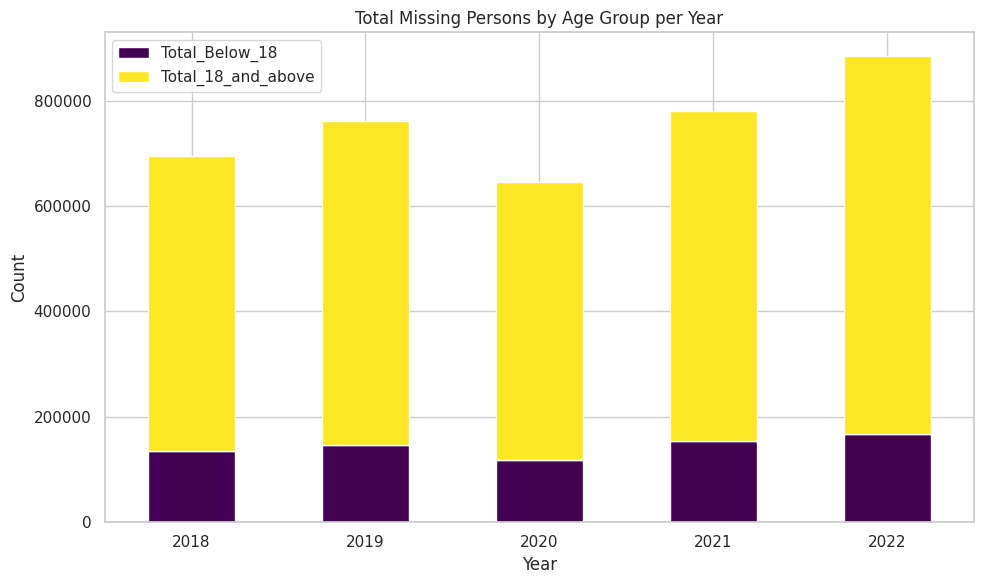

In [196]:
# Total missing cases per year
yearly_totals = data_clean.groupby('Year')[['Total_Below_18', 'Total_18_and_above']].sum()
yearly_totals.plot(kind='bar', stacked=True, figsize=(10,6), colormap='viridis')
plt.title("Total Missing Persons by Age Group per Year")
plt.ylabel("Count")
plt.xlabel("Year")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

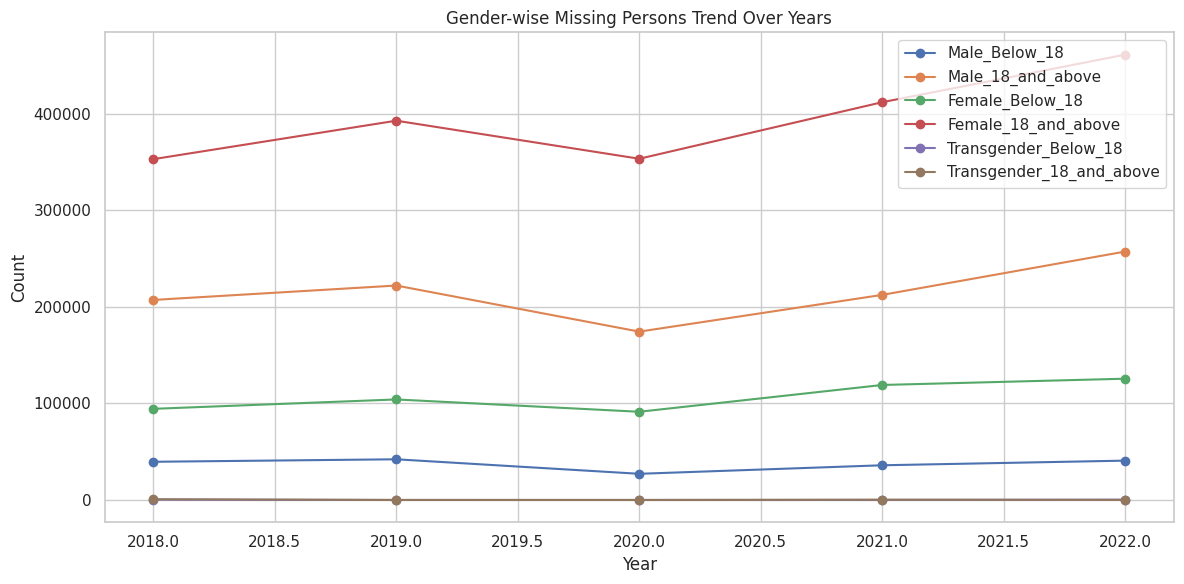

In [197]:
# Gender-wise missing trends
gender_trends = data_clean.groupby('Year')[
    ['Male_Below_18', 'Male_18_and_above',
     'Female_Below_18', 'Female_18_and_above',
     'Transgender_Below_18', 'Transgender_18_and_above']
].sum()

gender_trends.plot(kind='line', marker='o', figsize=(12, 6))
plt.title("Gender-wise Missing Persons Trend Over Years")
plt.ylabel("Count")
plt.xlabel("Year")
plt.grid(True)
plt.tight_layout()
plt.show()


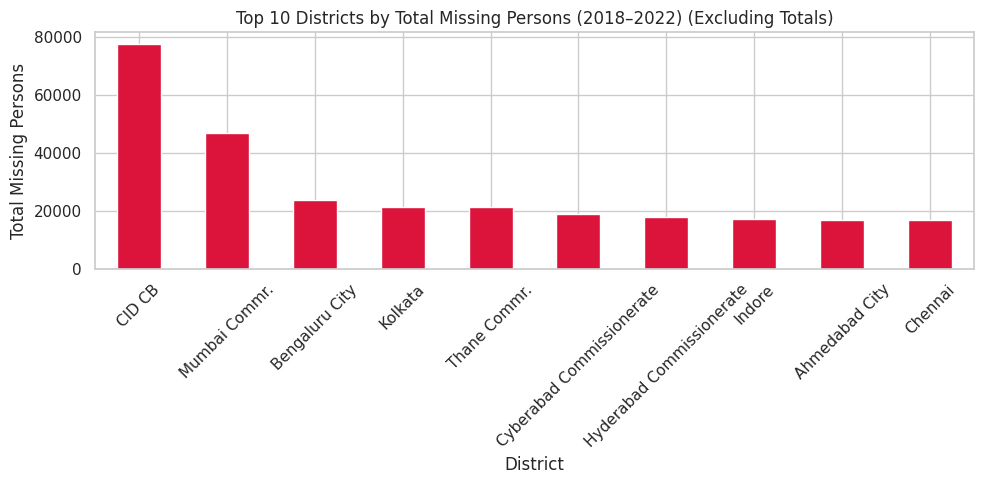

In [198]:
# Top 10 Districts with Most Total Missing Persons
# Clean the district names for consistent comparison
data_clean['District_clean'] = data_clean['District'].str.strip().str.lower()

# Filter out 'total' and 'total districts' properly
filtered_data = data_clean[~data_clean['District_clean'].isin(['total', 'total districts'])].copy()

# Compute total missing persons
filtered_data['Total_Missing'] = filtered_data['Total_Below_18'] + filtered_data['Total_18_and_above']

# Group and plot top 10 districts
top_districts = filtered_data.groupby('District')['Total_Missing'].sum().sort_values(ascending=False).head(10)

top_districts.plot(kind='bar', figsize=(10, 5), color='crimson')
plt.title("Top 10 Districts by Total Missing Persons (2018–2022) (Excluding Totals)")
plt.ylabel("Total Missing Persons")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [199]:
plt.figure(figsize=(14, 16))
sns.heatmap(pivot_table, cmap='YlGnBu', linewidths=0.5, vmax=5000)
plt.title("District-wise Missing Persons Over Years (Heatmap)")
plt.xlabel("Year")
plt.ylabel("District")
plt.tight_layout()
plt.show()


NameError: name 'pivot_table' is not defined

<Figure size 1400x1600 with 0 Axes>

In [ ]:
sns.boxplot(x='Year', y='Total_Missing', data=filtered_data)
plt.title("Year-wise Distribution of Missing Persons (Outlier Insight)")


# Feature Scaling

> In order to avoid inaccurate features and collinearity;

The dataset has columns such as:

*   Total Columns: Total_Male, Total_Female, Total_Transgender, and Grand_Total

*   Some columns are simply sums of others (for example, if Grand_Total equals the sum of Total_Male, Total_Female, and Total_Transgender, or if the overall totals are the sums of the age-specific columns), then including both could introduce collinearity.




In [200]:

# Select the features for clustering
features = ['Male_Below_18', 'Male_18_and_above', 'Female_Below_18', 'Female_18_and_above']
X = data_clean[features].copy()

# Retain label columns for interpretation
labels = data_clean[['State', 'District', 'Year']].copy()
"""
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)"""


'\n# Standardize the features\nscaler = StandardScaler()\nX_scaled = scaler.fit_transform(X)'

In [201]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)


**Determining the optimal number of clusters to use for K Means using elbow method:**

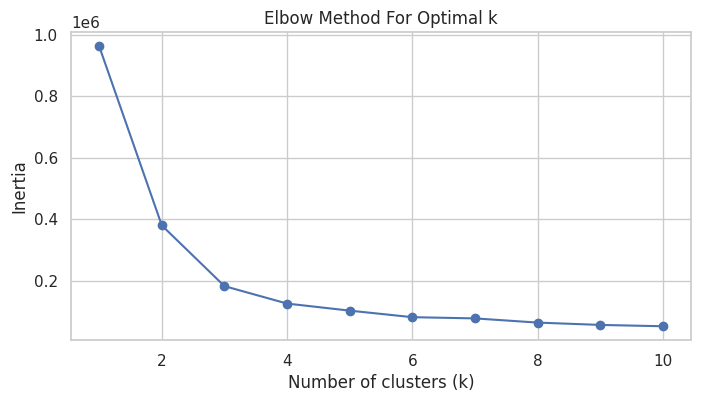

In [202]:


inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()


# K Means Clustering

In [203]:

# Replace 'optimal_k' with the number determined from the Elbow Method
optimal_k = 4  # Example value
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels to your labels DataFrame
labels['Cluster'] = clusters


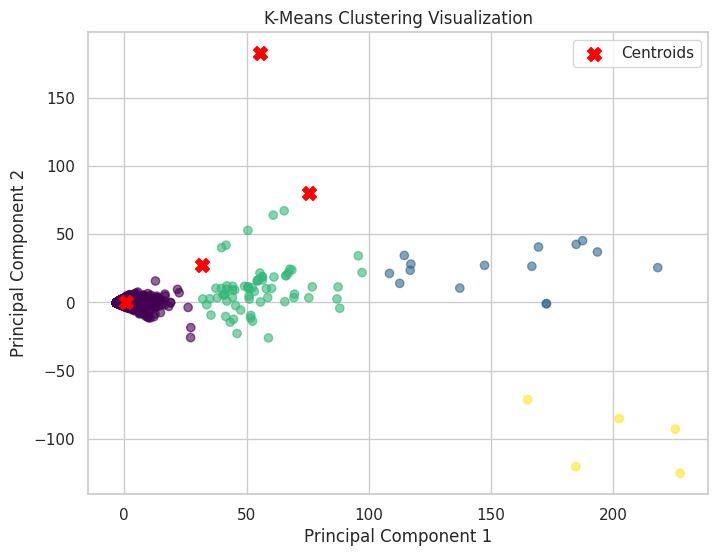

In [204]:


pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.6)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
            c='red', s=100, marker='X', label='Centroids')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-Means Clustering Visualization')
plt.legend()
plt.show()


In [205]:
score = silhouette_score(X_scaled, clusters)
print(f'K-Means Clustering Silhouette Score: {score:.2f}')


K-Means Clustering Silhouette Score: 0.94


A silhouette score of 0.95 in K-Means clustering is very high, and here's what it means:

The clustering results are excellent.

Clusters are well-separated and dense (i.e., data points within a cluster are very similar to each other and very different from points in other clusters).

Data is likely highly structured and suitable for K-Means.

In [206]:

# Combine the original features with cluster labels
clustered_data = pd.concat([X, labels['Cluster']], axis=1)

# Calculate mean values for each cluster
cluster_means = clustered_data.groupby('Cluster').mean()
print(cluster_means)


         Male_Below_18  Male_18_and_above  Female_Below_18  \
Cluster                                                      
0            21.080939         119.750823        58.172845   
1          1893.000000       10670.800000      6874.866667   
2           806.641791        3661.507463      2333.343284   
3          1400.200000       24349.400000      1964.600000   

         Female_18_and_above  
Cluster                       
0                 214.844483  
1               20532.666667  
2                7637.656716  
3               34521.800000  


*Pairplot for Feature Distribution:*

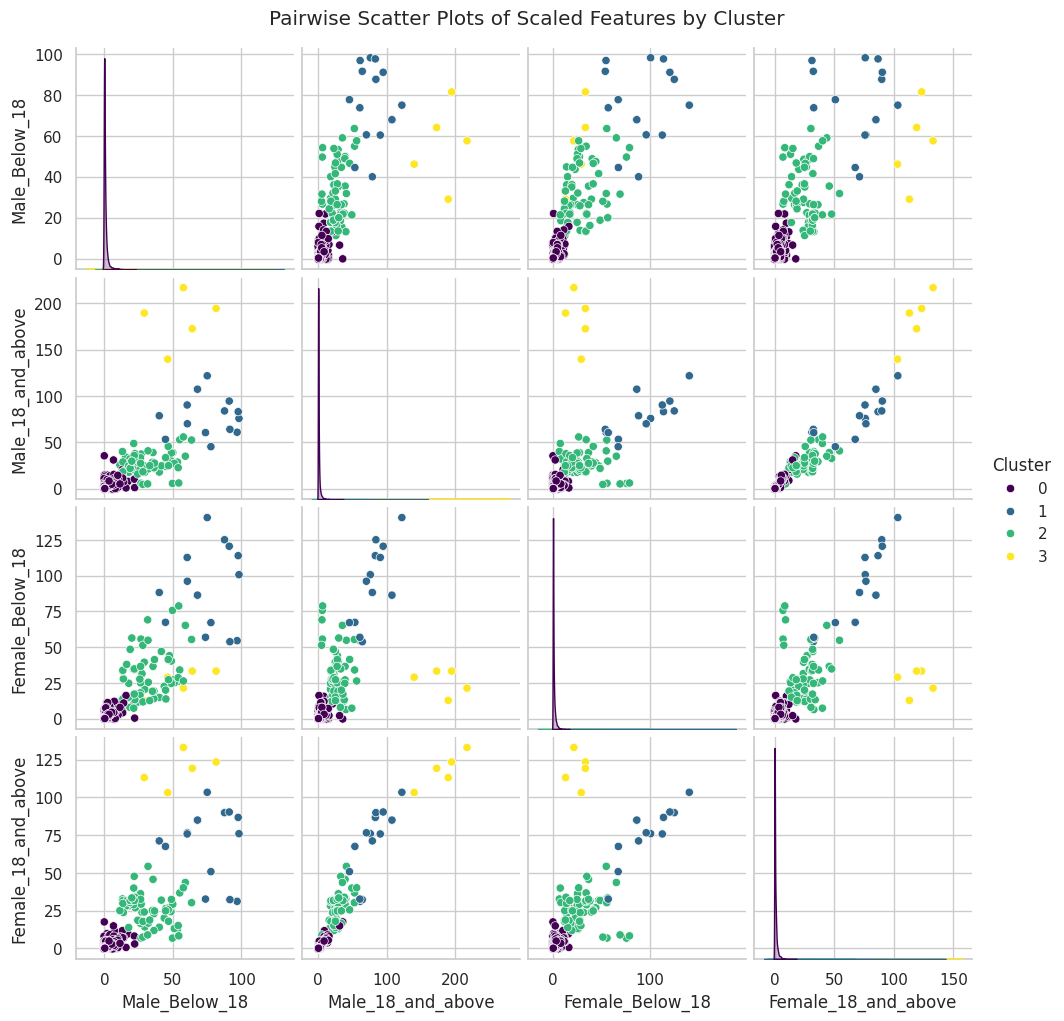

In [207]:
import seaborn as sns
import pandas as pd

# Combine the scaled features and cluster labels into one DataFrame for plotting
df_plot = pd.DataFrame(X_scaled, columns=features)
df_plot['Cluster'] = kmeans.labels_

sns.pairplot(df_plot, hue='Cluster', palette='viridis')
plt.suptitle('Pairwise Scatter Plots of Scaled Features by Cluster', y=1.02)
plt.show()


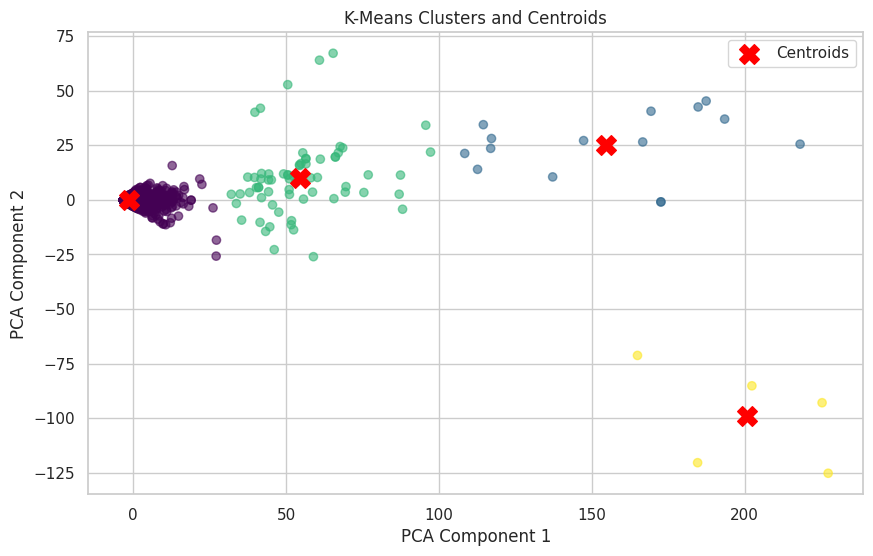

In [208]:
centers = kmeans.cluster_centers_
centers_pca = pca.transform(centers)

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, cmap='viridis', alpha=0.6)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c='red', marker='X', s=200, label='Centroids')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('K-Means Clusters and Centroids')
plt.legend()
plt.show()


# DBSCAN  (Density-Based Spatial Clustering of Applications with Noise)

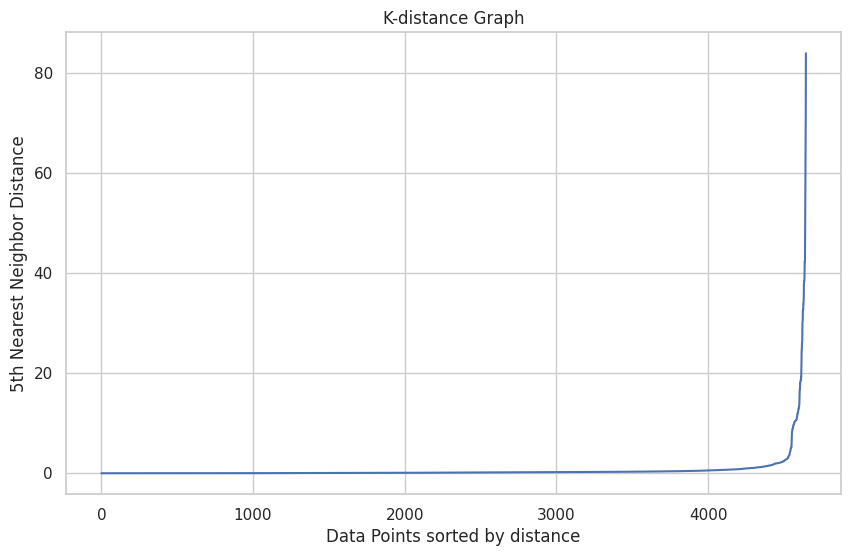

In [209]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

# Use min_samples (say 5) to compute the k-nearest neighbors distance
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

# Sort and plot the distances for the 5th nearest neighbor
distances = np.sort(distances[:, 4], axis=0)
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.xlabel('Data Points sorted by distance')
plt.ylabel('5th Nearest Neighbor Distance')
plt.title('K-distance Graph')
plt.show()


From the inspection of the above graph:

*    The elbow seems to occur around a distance of approximately 1.8 to 2.2 on the y-axis.

*    This implies that a good starting value for eps is around 2.0 (or just below it).

*    Using a smaller eps (like 0.5) was too restrictive, treating most points as noise and merging the rest into a single cluster.

In [210]:
from sklearn.cluster import DBSCAN

# Try with eps around the elbow value
dbscan = DBSCAN(eps=2, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)

# Check clustering results
n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f"Estimated number of clusters: {n_clusters}")
print(f"Estimated number of noise points: {n_noise}")


Estimated number of clusters: 5
Estimated number of noise points: 153


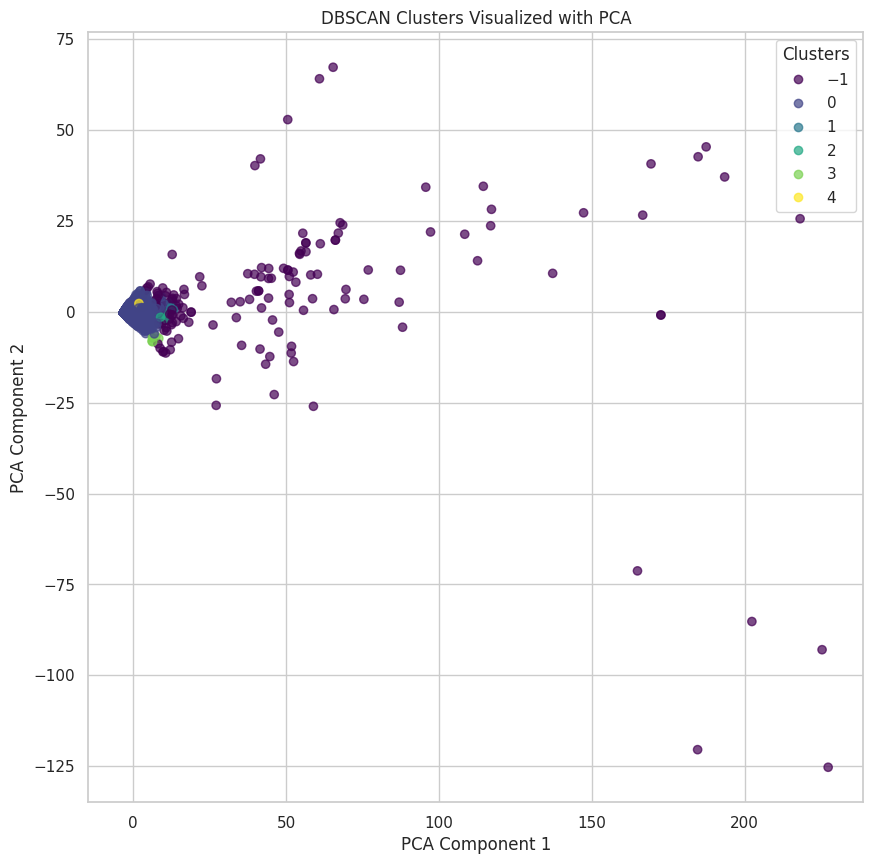

In [211]:
# Use PCA to reduce dimensionality for visualization:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 10))
# Use the DBSCAN labels for color coding; noise points will have label -1.
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, cmap='viridis', alpha=0.7)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('DBSCAN Clusters Visualized with PCA')
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.show()

In [212]:
# Note: DBSCAN marks noise points as -1.
labels['Cluster'] = dbscan_labels
print("\nCluster assignment on label data:")
print(labels.head())


Cluster assignment on label data:
             State          District  Year  Cluster
0   Andhra Pradesh         Anantapur  2018        0
1   Andhra Pradesh          Chittoor  2018        0
2   Andhra Pradesh          Cuddapah  2018        0
3   Andhra Pradesh     East Godavari  2018        0
4   Andhra Pradesh  Guntakal Railway  2018        0


In [213]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Filter out noise points (-1) for silhouette score (since silhouette score can't be computed on a single cluster)
mask = dbscan.labels_ != -1
if len(set(dbscan.labels_[mask])) > 1:  # Silhouette needs at least 2 clusters (excluding noise)
    sil_score = silhouette_score(X_scaled[mask], dbscan.labels_[mask])
    print(f"Silhouette Score (excluding noise): {sil_score:.4f}")
else:
    print("Silhouette Score: Not applicable (less than 2 clusters)")



Silhouette Score (excluding noise): 0.6997


In [214]:

# Davies-Bouldin Score can include all clusters, including noise
# However, it assumes labels >= 0, so we exclude noise here too
if len(set(dbscan.labels_[mask])) > 1:
    db_score = davies_bouldin_score(X_scaled[mask], dbscan.labels_[mask])
    print(f"Davies-Bouldin Score (excluding noise): {db_score:.4f}")
else:
    print("Davies-Bouldin Score: Not applicable (less than 2 clusters after removing noise)")

Davies-Bouldin Score (excluding noise): 0.3994


# Agglomerative Clustering

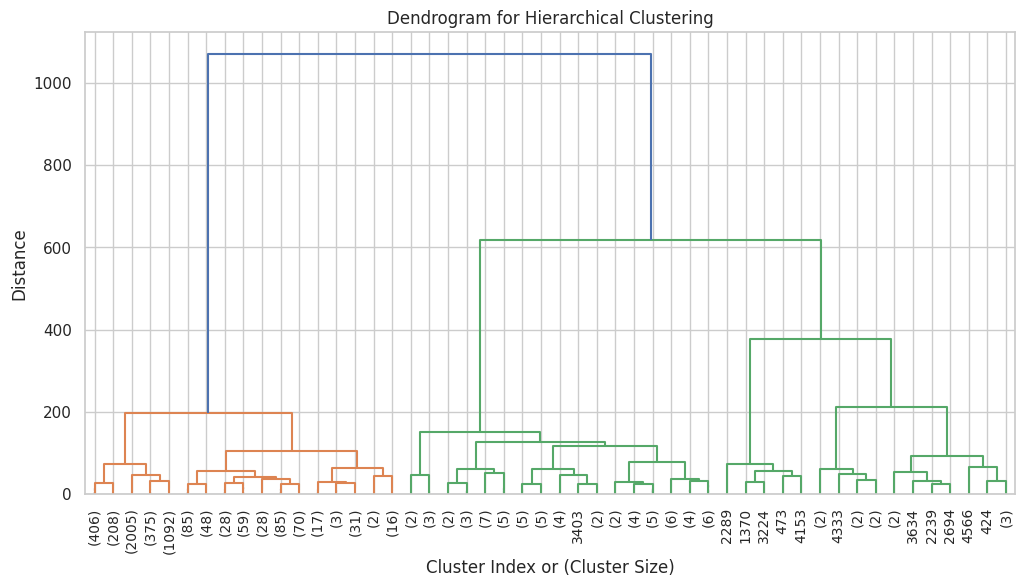

In [215]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

# Assume X_scaled is your scaled data from RobustScaler (or StandardScaler)
# For example: X_scaled = scaler.fit_transform(X)

# Perform hierarchical/agglomerative clustering with the Ward method
Z = linkage(X_scaled, method='ward')

# Plot the dendrogram
plt.figure(figsize=(12, 6))
dendrogram(Z,
           truncate_mode='lastp',    # show only the last p merged clusters
           p=50,                    # adjust this based on your dataset
           leaf_rotation=90.,       # rotates the x-axis labels
           leaf_font_size=10.,      # font size for the x-axis labels
           show_contracted=True)    # to get a distribution impression of the distances
plt.title('Dendrogram for Hierarchical Clustering')
plt.xlabel('Cluster Index or (Cluster Size)')
plt.ylabel('Distance')
plt.show()


In [216]:

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load your data
df = pd.read_csv('DistrictwiseMissingPersons2022.csv')

# Drop non-numeric or unnecessary columns (adjust this line based on your actual dataset)
X = df.select_dtypes(include=[np.number]).dropna()

# Scale the data
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# Apply Agglomerative Clustering
agglo = AgglomerativeClustering(n_clusters=5)  # You can tune this value based on dendrogram or trial
labels = agglo.fit_predict(X_scaled)

# Evaluation Metrics
sil_score = silhouette_score(X_scaled, labels)
db_score = davies_bouldin_score(X_scaled, labels)

print(f"Estimated number of clusters: {len(set(labels))}")
print(f"Silhouette Score: {sil_score:.4f}")
print(f"Davies-Bouldin Score: {db_score:.4f}")

# PCA for 2D visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)



Estimated number of clusters: 5
Silhouette Score: 0.9481
Davies-Bouldin Score: 0.4634


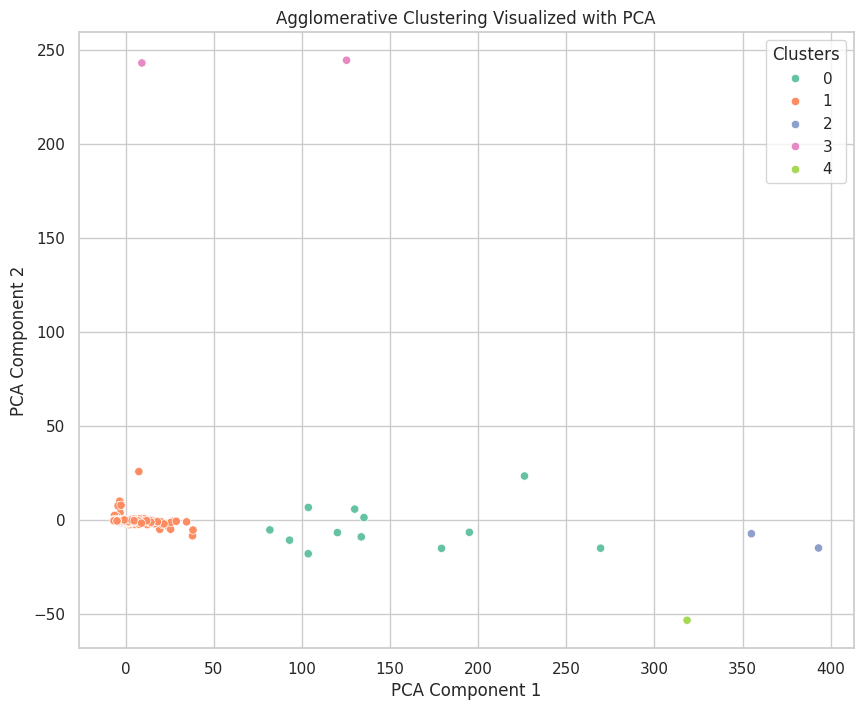

In [217]:

# Visualization
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette="Set2", legend="full")
plt.title("Agglomerative Clustering Visualized with PCA")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Clusters")
plt.show()

# Divisive Clustering